In [ ]:
import ray
import time
from ray.util.state import get_actor
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune, air
from ray.rllib.core.models.configs import MLPHeadConfig
from ray.rllib.core.models.catalog import Catalog
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.annotations import OverrideToImplementCustomLogic
from gymnasium.spaces import Box
from ray.rllib.examples.models.centralized_critic_models import YetAnotherTorchCentralizedCriticModel
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig
import ray.rllib.algorithms.ppo as ppo
from ray.rllib.utils.typing import Dict, TensorType, List, ModelConfigDict
import gymnasium as gym
import matplotlib.pyplot as plt
from ray.rllib.models.torch.misc import SlimFC, AppendBiasLayer
from ray.rllib.policy.torch_policy import TorchPolicy
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
import numpy as np
from ray import tune
import math
from torch.distributions.normal import Normal
import pandas as pd

In [ ]:
torch, nn = try_import_torch()

In [ ]:
ray.init()

In [ ]:
global adder
adder = 1.0000001
global num_gaussians
num_gaussians = 2
global parquet_path
parquet_path = "results/logs/sgd_update2.parquet"

class CustomTorchModelMOG(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModelMOG, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        nn.Module.__init__(self)
        
        self.actor_fcnet = TorchFC(obs_space, action_space, 2, model_config, name + "_actor")
        
        torch.autograd.set_detect_anomaly(True)
        
        self.critic_fcnet = TorchFC(obs_space, action_space, num_gaussians*3, model_config, name + "_critic")
        
        self.log_step = 0
        
        self.log_data = pd.DataFrame(columns = ['logp', 'loga', 'summing_log', 'mus', 'mu_current', 'td_targets',
                'sigma_current', 'alpha_current'])
        
#         self.mu = nn.Parameter(torch.zeros(num_gaussians, output_dim))
        
#         self.sigma = nn.Parameter(torch.full((num_gaussians, output_dim), 0.0001))
        
#         self.alpha = nn.Parameter(torch.full((num_gaussians,), 1.0 / num_gaussians))
        
    @OverrideToImplementCustomLogic
    def forward(self, input_dict, state, seq_lens):
        # Actor forward pass
        action_logits, _ = self.actor_fcnet(input_dict, state, seq_lens)
        
        # Critic forward pass
        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)
        
        self.value_ouput_tensor = value_output
        #this is redudnant since it already outputs a tensor
    
        '''
        -value_output is a function of the number of components we wish to have for the MoGs
        --Because of this, it makes sense to have the arrays slice based on the number of components input
          from a user
        '''
        
        #fix this with slicing
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        self._u = means
        
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
        self._sigmas = sigmas
        
        alphas = value_output[:, i*2:]
        alphas = torch.nn.functional.softmax(alphas, dim=-1)
        self._alphas = alphas

        return action_logits, state

    @OverrideToImplementCustomLogic
    def value_function(self):
        multiply = self._u * self._alphas
        values = torch.sum(multiply, dim = 1)
        return values
    
    '''
    -We need the sample from MoG as a means of doing the n-step return which is common for reducing
    variance, but at the cost of increasing bias...fortunately, betwen 3-7 samples is enough to 
    approximately have the bias/variance tradeoff nearly equal
    --This is important to do to increase convergence and also decrease computation time compared to
    the Monte Carlo approach which is sampling a bunch of trajectories
    
    -From the sample we need to compute the log probabilites of the samples
    '''

    def predict_gmm_params(self, cur_obs):
        input_dict = {'obs': cur_obs}
        state = []  
        seq_lens = None
        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)        
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
#         alphas = value_output[:, i*2:]
        alphas_raw = value_output[:, i*2:]
        alphas = torch.tanh(alphas_raw)
#         alphas = torch.nn.functional.softmax(alphas, dim=-1)
        
        return means, sigmas, alphas
    
    def generate_target_gmm_params(self, rewards, next_states, dones, gamma=0.99):

        mu_next, sigma_next, w_next = self.predict_gmm_params(next_states)
        mu_target = mu_next + (rewards.unsqueeze(-1) * gamma) * (1 - dones.unsqueeze(-1).float())
        sigma_target = sigma_next
        w_target = w_next
    
#         self.log_to_dataframe(logp = None, loga = None, summing_log = None, mus = None,
#                              mu_next = mu_next, sigma_next = sigma_next, w_next = w_next,
#                              mu_target = mu_target, sigma_target = sigma_target, w_target = w_target,
#                              alpha_current = None)
    
    
    
        return mu_target.clone().detach(), sigma_target.clone().detach(), w_target.clone().detach()
    
    def log_to_dataframe(self, logp, loga, summing_log, mus, mu_current, td_targets, sigma_current,
                         alpha_current):
        new_log_entry = pd.DataFrame({
            'iteration': [self.log_step],
            'logp': [logp.mean().item() if logp is not None else np.nan],
            'loga': [loga.mean().item() if loga is not None else np.nan],
            'summing_log': [summing_log.mean().item() if summing_log is not None else np.nan],
            'mus': [mus.detach().cpu().numpy().flatten().min() if mus is not None else np.nan],
            'mu_current': [mu_current.detach().cpu().min().item() if mu_current is not None else np.nan],
            'td_targets': [td_targets.detach().cpu().numpy().mean() if td_targets is not None else np.nan],
            'sigma_current': [sigma_current.detach().cpu().numpy().flatten().min() if sigma_current is not None else np.nan],
            'alpha_current': [alpha_current.detach().cpu().numpy().flatten().min() if alpha_current is not None else np.nan], 
        })
        
        self.log_data = pd.concat([self.log_data, new_log_entry], ignore_index = True)
        
        if self.log_step % 100 == 0:
            self.save_to_parquet()
        self.log_step += 1
        
    def save_to_parquet(self):
        self.log_data.to_parquet(parquet_path)
    

    def compute_log_likelihood(self, td_targets, mu_current, sigma_current, alpha_current):
        td_targets_expanded = td_targets.unsqueeze(1)         
        '''
        Important here: we have a mix of shapes of the arrays since td_targets will be [N,1] and the
        mu_current will be [N,num_gaussians] so we have to do the same trick to get a matrix which
        has all of these compared (such as the 2048x3x1 + 2048x1x3 but two dimensions not three)
        
        td_targets =                            [N]
        td_targets_expanded =                  [N,1]
        sigma_current =                   [N, num_gaussians]
        sigma_current_expanded =        [N, num_gaussians, 1]
        alpha_current_expanded =        [N, num_gaussians, 1]
        when subtracted =               [N, num_gaussians, 1] for the exp()
        '''

        sigma_clamped = torch.clamp(sigma_current, 1e-8, 1e2)
        
        log_2_pi = torch.log(2*torch.tensor(math.pi))
        factor = -torch.log(sigma_clamped) - 0.5*log_2_pi 
        mus = td_targets_expanded - mu_current
        
        logp = torch.clamp(factor - torch.square(mus)/ (2*torch.square(sigma_clamped)), -1e10, 10)
        loga = torch.clamp(torch.nn.functional.log_softmax(alpha_current, dim=-1), -20, 1)
        
        clamped_exp = torch.clamp(-torch.logsumexp(logp + loga, dim=-1), -1e-8, 1e5)
        summing_log = clamped_exp
        
        
        self.log_to_dataframe(logp = logp, loga = loga, summing_log = summing_log, mus = mus,
                             mu_current = mu_current,  td_targets = td_targets, sigma_current = sigma_current,
                            alpha_current = alpha_current)

        return summing_log


    @OverrideToImplementCustomLogic
    def custom_loss(self, policy_loss, sample_batch):
        
        gamma = 0.99
        cur_obs = sample_batch[SampleBatch.CUR_OBS]
        next_states = sample_batch[SampleBatch.NEXT_OBS]
        rewards = sample_batch[SampleBatch.REWARDS]
        dones = sample_batch[SampleBatch.DONES]

        mu_current, sigma_current, alpha_current = self.predict_gmm_params(cur_obs)
        mu_next, sigma_next, alpha_next = self.predict_gmm_params(next_states)
        alpha_next = torch.nn.functional.softmax(alpha_next, dim=-1)

        next_state_values = torch.sum(mu_next * alpha_next, dim=1).clone().detach()
        td_targets = rewards + gamma * next_state_values * (1 - dones.float())
        

        log_likelihood = self.compute_log_likelihood(td_targets, mu_current, sigma_current, alpha_current)
        log_likelihood = torch.clamp(log_likelihood, -10, 80)
        nll_loss = torch.mean(log_likelihood)
        
        total_loss = [loss + nll_loss for loss in policy_loss]
        
        '''
        Thought: what if I use another neural network to determine the weights for each of the
        loss terms? I.e. have a layer of [64,64] with two inputs and two outputs ran through a softmax
        layer
        
        Tried this, but didn't seem to work
        '''
        return total_loss

In [5]:
 ModelCatalog.register_custom_model("custom_torch_model_mog", CustomTorchModelMOG)

In [6]:
config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    kl_coeff = 0.5,
    num_sgd_iter = 10,
    lr = 0.0001,
    vf_loss_coeff = 1.0,
    vf_clip_param = 0.5,
    clip_param = 0.2,
    grad_clip_by ='norm', 
    train_batch_size = 19_200, 
    sgd_minibatch_size = 4096,
    grad_clip = 1.0,
    model={'custom_model': 'custom_torch_model_mog', 
    'vf_share_layers': False, 'fcnet_hiddens': [1024,1024],'fcnet_activation': 'LeakyReLU'}
).environment(env='HalfCheetah-v4'
).resources(
num_gpus = 1
)

#lr from 0.00025 -> 0.00010
#vf_clip_param from 1.0 -> 0.5
#two gaussians 
#clamped loga and fixed logging
#applied tanh to alphas output for the loga logsoftmax
#changed total_loss = [loss + nll_loss for loss in policy_loss] to
#Does rllib handle adding the advantages to the custom loss?
#Does rllib handle exploration / entropy for me for a custom loss?

num_iterations = 500

algo = config.build()
rewards = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    
ray.shutdown()

C:\Users\tyler\anaconda3\lib\site-packages\ray\rllib\algorithms\algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\tyler\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\tyler\anaconda3\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You cou

Iteration: 0, Mean Reward: -419.0097440653642
Iteration: 1, Mean Reward: -414.7335627840066
Iteration: 2, Mean Reward: -389.77258788019634
Iteration: 3, Mean Reward: -375.5755621155497
Iteration: 4, Mean Reward: -365.4553933911105
Iteration: 5, Mean Reward: -358.1116114711334
Iteration: 6, Mean Reward: -354.42245138926484
Iteration: 7, Mean Reward: -355.48880660442614
Iteration: 8, Mean Reward: -362.1370605821869
Iteration: 9, Mean Reward: -370.0010346029911
Iteration: 10, Mean Reward: -365.2426772911211
Iteration: 11, Mean Reward: -347.3380816231261
Iteration: 12, Mean Reward: -341.17163118968136
Iteration: 13, Mean Reward: -323.135688307612
Iteration: 14, Mean Reward: -302.79599136737755
Iteration: 15, Mean Reward: -281.09732160893003
Iteration: 16, Mean Reward: -255.49999562098247
Iteration: 17, Mean Reward: -221.6645519688949
Iteration: 18, Mean Reward: -181.91541993058897
Iteration: 19, Mean Reward: -138.96771515691103
Iteration: 20, Mean Reward: -105.37987386969567
Iteration: 21,

Iteration: 175, Mean Reward: 20.705172981618748
Iteration: 176, Mean Reward: -0.30233950874197346
Iteration: 177, Mean Reward: -12.910792211204354
Iteration: 178, Mean Reward: 12.032355205285729
Iteration: 179, Mean Reward: 3.732233068407615
Iteration: 180, Mean Reward: 20.693289686238355
Iteration: 181, Mean Reward: 62.2546558748094
Iteration: 182, Mean Reward: 65.21354453024733
Iteration: 183, Mean Reward: 39.9403230349524
Iteration: 184, Mean Reward: 62.44568117051446
Iteration: 185, Mean Reward: 73.77114913002725
Iteration: 186, Mean Reward: 61.921178553530964
Iteration: 187, Mean Reward: 84.26061591493718
Iteration: 188, Mean Reward: 80.13885368179729
Iteration: 189, Mean Reward: 130.16031658649857
Iteration: 190, Mean Reward: 169.62153040099028
Iteration: 191, Mean Reward: 235.52335036681714
Iteration: 192, Mean Reward: 250.4760456253996
Iteration: 193, Mean Reward: 323.6998468374647
Iteration: 194, Mean Reward: 364.4607138468154
Iteration: 195, Mean Reward: 370.08263300159916
It

KeyboardInterrupt: 

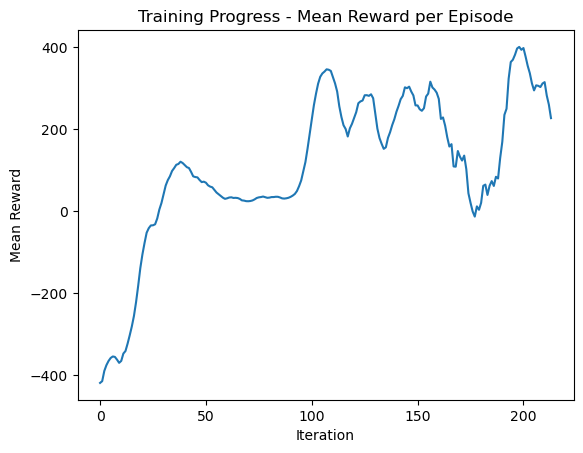

In [7]:
plt.plot(rewards)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('MOG and Energy Distance - HalfCheetah-v4')
plt.show()

In [25]:
try:
    # Example: Reading a Parquet file with pandas
    df = pd.read_parquet('C:/Users/tyler/OneDrive/Desktop/PhD Stuff/code/results/logs/sgd_update.parquet')
except OSError as e:
    print(f"Failed to read file due to: {e}")
    # Handle the error: retry, log, raise a custom exception, etc.

In [26]:
df.tail(1000)

,logp,loga,summing_log,mus,mu_current,td_targets,sigma_current,alpha_current,iteration
2401,-2.811763,-1.121741,2.573337,-32.430096,27.767029,53.121498,0.729355,-1.0,2401.0
2402,-3.338326,-1.123491,2.953299,-67.707977,27.431227,72.460426,0.608403,-1.0,2402.0
2403,-3.139034,-1.124075,2.789466,-58.064117,28.063084,63.606621,0.407820,-1.0,2403.0
2404,-2.943263,-1.123170,2.711139,-37.850986,27.694229,53.097675,0.369498,-1.0,2404.0
2405,-3.604448,-1.124558,3.164419,-62.379929,27.140778,73.026123,0.389709,-1.0,2405.0
...,...,...,...,...,...,...,...,...,...
3396,-3.800832,-1.123261,3.649959,-107.586777,10.485410,68.187675,0.626794,-1.0,3396.0
3397,-3.381680,-1.117366,3.118960,-91.456467,12.394515,48.317848,0.884947,-1.0,3397.0
3398,-3.611029,-1.123329,3.482275,-97.683296,17.383854,62.655514,0.731698,-1.0,3398.0
3399,-3.299457,-1.121474,3.206684,-103.928795,19.046932,53.489231,0.838671,-1.0,3399.0


In [10]:
import plotly.express as px
import plotly.graph_objects as go
import kaleido

In [11]:
from plotly.subplots import make_subplots

In [22]:
# Set the maximum number of rows to display
# pd.set_option('display.max_rows', 50)  # or any number you desire

# Now, when you use df.tail(50), it will display all 50 rows
print(df.tail(50))

               logp  loga  summing_log         mus  mu_current  td_targets  \
17651     -4.279659 -10.0     3.906177 -369.944122  -76.057281  142.642883   
17652     -4.341623 -10.0     3.976910 -367.942474  -78.378403  141.203049   
17653     -4.396017 -10.0     4.025292 -132.683807 -316.207306   40.633327   
17654     -5.356571 -10.0     4.251629 -661.430481 -438.759827   50.336075   
17655     -4.204312 -10.0     3.940222 -112.544403 -201.547943   99.390800   
17656     -4.146684 -10.0     3.839602 -113.449814 -202.927536   98.010071   
17657     -5.241987 -10.0     4.021199 -668.480164 -448.875519   45.319557   
17658     -4.173312 -10.0     3.649297 -365.687408  -81.097130  133.440735   
17659     -4.172454 -10.0     3.562043 -139.764832 -324.509399   32.012848   
17660     -3.980839 -10.0     3.571647 -120.378914 -202.659851   95.169693   
17661     -4.234249 -10.0     3.723407 -370.586792  -87.622589  132.828949   
17662     -5.338886 -10.0     4.139242 -684.051147 -432.738037  

In [14]:
df.tail(50)

,logp,loga,summing_log,mus,mu_current,td_targets,sigma_current,alpha_current,iteration
17651,-4.279659,-10.0,3.906177,-369.944122,-76.057281,142.642883,1.785463,-89.098839,17651.0
17652,-4.341623,-10.0,3.976910,-367.942474,-78.378403,141.203049,1.997749,-88.953232,17652.0
17653,-4.396017,-10.0,4.025292,-132.683807,-316.207306,40.633327,2.294586,-86.536720,17653.0
17654,-5.356571,-10.0,4.251629,-661.430481,-438.759827,50.336075,1.901637,-160.491180,17654.0
17655,-4.204312,-10.0,3.940222,-112.544403,-201.547943,99.390800,2.827557,-60.288246,17655.0
17656,-4.146684,-10.0,3.839602,-113.449814,-202.927536,98.010071,3.087623,-60.122940,17656.0
17657,-5.241987,-10.0,4.021199,-668.480164,-448.875519,45.319557,2.590227,-160.905518,17657.0
17658,-4.173312,-10.0,3.649297,-365.687408,-81.097130,133.440735,3.512667,-89.361511,17658.0
17659,-4.172454,-10.0,3.562043,-139.764832,-324.509399,32.012848,3.717454,-85.668823,17659.0
17660,-3.980839,-10.0,3.571647,-120.378914,-202.659851,95.169693,3.699495,-60.119278,17660.0


In [27]:
fig = make_subplots(rows = 3, cols =1, shared_xaxes = True)
        
fig.add_trace(go.Scatter(y = df['mu_current'], mode = 'lines', name = 'mu current'), row = 1, col = 1)
fig.add_trace(go.Scatter(y = df['td_targets'], mode = 'lines', name = 'mu target'), row = 1, col = 1)

fig.add_trace(go.Scatter(y = df['sigma_current'], mode = 'lines', name = 'sigma current'), row = 2, col = 1)
# fig.add_trace(go.Scatter(y = df['sigma_target'], mode = 'lines', name = 'sigma target'), row = 2, col = 1)

fig.add_trace(go.Scatter(y = df['alpha_current'], mode = 'lines', name = 'w current'), row = 3, col = 1)
# fig.add_trace(go.Scatter(y = df['w_target'], mode = 'lines', name = 'w target'), row = 3, col = 1)

fig.update_layout(height = 600, width = 800, title_text = 'Analysis of NLL params', showlegend = True)

fig.show()

In [23]:
len(df['mus'][0])

8192

In [24]:
df['mus']

0      [-1.6179463, -1.6180012, -0.33178195, -0.40719...
1      [-1.6408172, -1.6483207, -0.9614751, -0.96329,...
2      [-0.8298162, -0.8508923, -1.1131694, -1.117172...
3      [-0.6816541, -0.6818176, -2.9012966, -2.907747...
4      [-0.7322153, -0.73349035, -3.096798, -3.103793...
                             ...                        
196    [2.445839, -3.2618942, 4.4131775, -1.186615, 2...
197    [35.223015, 10.081055, 7.4523773, -3.7533493, ...
198    [8.931747, -1.6473999, 22.399284, 0.51119995, ...
199    [14.434296, 3.4565582, 6.89637, -0.945076, 9.8...
200    [3.5252075, -3.6013489, 5.651924, -1.4404755, ...
Name: mus, Length: 201, dtype: object

In [28]:
fig = go.Figure()

# fig.add_trace(go.Scatter(y = rewards, mode = 'lines', name = 'Rewards'))
fig.add_trace(go.Scatter(y = df['logp'], mode = 'lines', name = 'logp'))
fig.add_trace(go.Scatter(y = df['loga'], mode = 'lines', name = 'loga'))
fig.add_trace(go.Scatter(y = df['summing_log'], mode = 'lines', name = 'summing log'))
fig.add_trace(go.Scatter(y = df['mus'], mode = 'lines', name = 'mus'))

fig.update_layout(title_text= 'nll params', xaxis_title = 'Iterations',
                 font = dict(
                     family = 'Times New Roman',
                     size = 18,
                 ))
# fig.write_image('/MoG_Performance.png')
#no internal dispersion and not normalized by N*N
fig.show()